In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
import torch.nn.functional as F

In [2]:
df_actions = pd.read_csv("df_actions_148K.csv")

In [3]:
df_actions.head()

,sequence_a,sequence_b,item_id_a,item_id_b,mode,is_directional,a_is_acting,score
0,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...,9606.ENSP00000000233,9606.ENSP00000263025,ptmod,f,f,150
1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MAQAAKQLKKIKDIEAQALQEQKEKEESNRKRRNRSRDRKKKADAA...,9606.ENSP00000000233,9606.ENSP00000265709,reaction,f,f,908
2,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MAQAAKQLKKIKDIEAQALQEQKEKEESNRKRRNRSRDRKKKADAA...,9606.ENSP00000000233,9606.ENSP00000265709,catalysis,t,t,908
3,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...,9606.ENSP00000000233,9606.ENSP00000263025,inhibition,t,t,154
4,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MAQAAKQLKKIKDIEAQALQEQKEKEESNRKRRNRSRDRKKKADAA...,9606.ENSP00000000233,9606.ENSP00000265709,binding,f,t,908


In [4]:
# Step 1: Create a mapping from protein IDs to indices
protein_ids = pd.concat([df_actions['item_id_a'], df_actions['item_id_b']]).unique()
protein_to_idx = {protein: idx for idx, protein in enumerate(protein_ids)}

# Step 2: Map interaction mode to integers
# mode_to_int = {mode: i for i, mode in enumerate(df_actions['mode'].unique())}
# df_actions['edge_type'] = df_actions['mode'].map(mode_to_int)

# --- Direction-aware edge construction ---
src_nodes = []
dst_nodes = []

for _, row in df_actions.iterrows():
    a = row['item_id_a']
    b = row['item_id_b']
    
    if row['is_directional'] == 't':
        if row['a_is_acting'] == 't':
            src_nodes.append(protein_to_idx[a])
            dst_nodes.append(protein_to_idx[b])
        else:
            src_nodes.append(protein_to_idx[b])
            dst_nodes.append(protein_to_idx[a])
    else:
        # Undirected → add both directions
        src_nodes.append(protein_to_idx[a])
        dst_nodes.append(protein_to_idx[b])
        src_nodes.append(protein_to_idx[b])
        dst_nodes.append(protein_to_idx[a])

edge_index = torch.tensor([src_nodes, dst_nodes], dtype=torch.long)

# Step 4: Create node features (one-hot encoding of sequences)
amino_acids = list("ACDEFGHIKLMNPQRSTVWXY")
encoder = OneHotEncoder(categories=[amino_acids], sparse_output=False)

node_features = []
for protein in protein_ids:
    sequence_a = df_actions[df_actions['item_id_a'] == protein]['sequence_a']
    sequence_b = df_actions[df_actions['item_id_b'] == protein]['sequence_b']
    
    if len(sequence_a) > 0:
        sequence = sequence_a.values[0]
    elif len(sequence_b) > 0:
        sequence = sequence_b.values[0]
    else:
        raise ValueError(f"Protein {protein} not found in either 'item_id_a' or 'item_id_b'.")
    
    encoded_seq = encoder.fit_transform(np.array(list(sequence)).reshape(-1, 1))
    node_features.append(encoded_seq.mean(axis=0))

node_features_array = np.array(node_features)

# Step 5: Create PyG Data object
data = Data(
    x=torch.tensor(node_features_array, dtype=torch.float),  # Node features
    edge_index=edge_index,  # Edge indices
    # edge_type=edge_type  # Edge types
)

In [5]:
# # Map interaction mode to integers
# mode_to_int = {mode: i for i, mode in enumerate(df_actions['mode'].unique())}
# df_actions['edge_type'] = df_actions['mode'].map(mode_to_int)

In [6]:
# # Step 1: Create a mapping from protein IDs to indices
# protein_ids = pd.concat([df_actions['item_id_a'], df_actions['item_id_b']]).unique()
# protein_to_idx = {protein: idx for idx, protein in enumerate(protein_ids)}

# # Step 2: Map interaction mode to integers
# mode_to_int = {mode: i for i, mode in enumerate(df_actions['mode'].unique())}
# df_actions['edge_type'] = df_actions['mode'].map(mode_to_int)

# # Step 3: Create edge index and edge type
# edge_index = torch.tensor([
#     [protein_to_idx[protein] for protein in df_actions['item_id_a']],
#     [protein_to_idx[protein] for protein in df_actions['item_id_b']]
# ], dtype=torch.long)

# edge_type = torch.tensor(df_actions['edge_type'].values, dtype=torch.long)

# # Step 4: Create node features (one-hot encoding of sequences)
# amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
# encoder = OneHotEncoder(categories=[amino_acids], sparse_output=False)

# node_features = []
# for protein in protein_ids:
#     sequence_a = df_actions[df_actions['item_id_a'] == protein]['sequence_a']
#     sequence_b = df_actions[df_actions['item_id_b'] == protein]['sequence_b']
    
#     if len(sequence_a) > 0:
#         sequence = sequence_a.values[0]
#     elif len(sequence_b) > 0:
#         sequence = sequence_b.values[0]
#     else:
#         raise ValueError(f"Protein {protein} not found in either 'item_id_a' or 'item_id_b'.")
    
#     encoded_seq = encoder.fit_transform(np.array(list(sequence)).reshape(-1, 1))
#     node_features.append(encoded_seq.mean(axis=0))

# node_features_array = np.array(node_features)

# # Step 5: Create PyG Data object
# data = Data(
#     x=torch.tensor(node_features_array, dtype=torch.float),  # Node features
#     edge_index=edge_index,  # Edge indices
#     edge_type=edge_type  # Edge types
# )

In [7]:
class GATLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GATLinkPrediction, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

In [8]:
# Step 1: Split edge_index and edge_type
edge_index = data.edge_index.numpy()
#edge_type = data.edge_type.numpy()

edge_index_train, edge_index_test = train_test_split(
    edge_index.T, test_size=0.2, random_state=42
)
edge_index_train, edge_index_val = train_test_split(
    edge_index_train, test_size=0.1, random_state=42
)

# Convert back to tensors
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long).t()
edge_index_val = torch.tensor(edge_index_val, dtype=torch.long).t()
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).t()

# edge_type_train = torch.tensor(edge_type_train, dtype=torch.long)
# edge_type_val = torch.tensor(edge_type_val, dtype=torch.long)
# edge_type_test = torch.tensor(edge_type_test, dtype=torch.long)

# Step 2: Generate negative samples
neg_edge_index_train = negative_sampling(edge_index_train, num_nodes=data.num_nodes)
neg_edge_index_val = negative_sampling(edge_index_val, num_nodes=data.num_nodes)
neg_edge_index_test = negative_sampling(edge_index_test, num_nodes=data.num_nodes)

# Step 3: Initialize the model
# Initialize the GAT model
model = GATLinkPrediction(
    in_channels=data.num_features,
    hidden_channels=8,  # Adjust based on your dataset size
    out_channels=8,  # Adjust based on your dataset size
    heads=2  # Number of attention heads
)

# Step 4: Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 5: Training loop
def train():
    model.train()
    optimizer.zero_grad()
    
    pos_edge_index = edge_index_train
    neg_edge_index = neg_edge_index_train
    
    z = model(data.x, pos_edge_index)
    pos_score = model.decode(z, pos_edge_index)
    neg_score = model.decode(z, neg_edge_index)
    
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones(pos_score.size(0)))
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros(neg_score.size(0)))
    loss = pos_loss + neg_loss
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.3862
Epoch: 002, Loss: 1.3857
Epoch: 003, Loss: 1.3853
Epoch: 004, Loss: 1.3849
Epoch: 005, Loss: 1.3848
Epoch: 006, Loss: 1.3844
Epoch: 007, Loss: 1.3841
Epoch: 008, Loss: 1.3838
Epoch: 009, Loss: 1.3835
Epoch: 010, Loss: 1.3831
Epoch: 011, Loss: 1.3826
Epoch: 012, Loss: 1.3821
Epoch: 013, Loss: 1.3815
Epoch: 014, Loss: 1.3809
Epoch: 015, Loss: 1.3802
Epoch: 016, Loss: 1.3795
Epoch: 017, Loss: 1.3787
Epoch: 018, Loss: 1.3778
Epoch: 019, Loss: 1.3768
Epoch: 020, Loss: 1.3757
Epoch: 021, Loss: 1.3745
Epoch: 022, Loss: 1.3733
Epoch: 023, Loss: 1.3719
Epoch: 024, Loss: 1.3704
Epoch: 025, Loss: 1.3688
Epoch: 026, Loss: 1.3670
Epoch: 027, Loss: 1.3651
Epoch: 028, Loss: 1.3631
Epoch: 029, Loss: 1.3610
Epoch: 030, Loss: 1.3587
Epoch: 031, Loss: 1.3562
Epoch: 032, Loss: 1.3536
Epoch: 033, Loss: 1.3510
Epoch: 034, Loss: 1.3482
Epoch: 035, Loss: 1.3455
Epoch: 036, Loss: 1.3424
Epoch: 037, Loss: 1.3391
Epoch: 038, Loss: 1.3362
Epoch: 039, Loss: 1.3331
Epoch: 040, Loss: 1.3294


In [9]:
def evaluate(edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model(data.x, edge_index)
        pos_score = model.decode(z, edge_index).sigmoid().cpu().numpy()
        neg_score = model.decode(z, neg_edge_index).sigmoid().cpu().numpy()
        
        y_true = np.hstack([np.ones(pos_score.size), np.zeros(neg_score.size)])
        y_score = np.hstack([pos_score, neg_score])
        
        auc_roc = roc_auc_score(y_true, y_score)
        auc_pr = average_precision_score(y_true, y_score)
        
        return auc_roc, auc_pr

In [10]:
# Evaluate on validation set
val_auc_roc, val_auc_pr = evaluate(edge_index_val, neg_edge_index_val)
print(f"Validation AUC-ROC: {val_auc_roc:.4f}, Validation AUC-PR: {val_auc_pr:.4f}")

# Evaluate on test set
test_auc_roc, test_auc_pr = evaluate(edge_index_test, neg_edge_index_test)
print(f"Test AUC-ROC: {test_auc_roc:.4f}, Test AUC-PR: {test_auc_pr:.4f}")

Validation AUC-ROC: 0.7482, Validation AUC-PR: 0.7603
Test AUC-ROC: 0.8154, Test AUC-PR: 0.8235


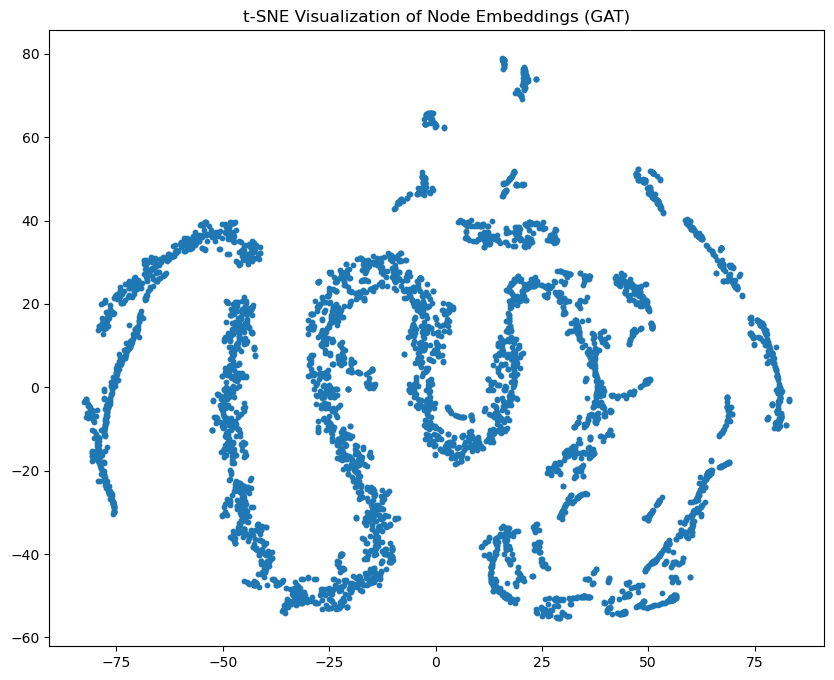

In [11]:
z = model.encode(data.x, data.edge_index).detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(10, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10)
plt.title("t-SNE Visualization of Node Embeddings (GAT)")
plt.show()

In [12]:
torch.save(model.state_dict(), "gat_link_prediction_model_148K_directional.pth")

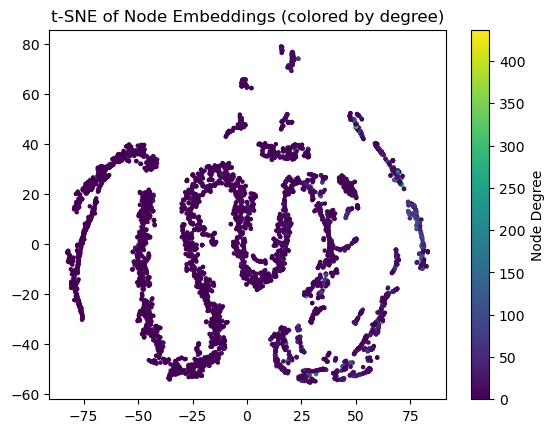

In [13]:
import networkx as nx
from torch_geometric.utils import to_networkx

g = to_networkx(data, to_undirected=True)
degree = dict(g.degree())
degrees = np.array([degree[i] for i in range(len(degree))])

plt.scatter(z_2d[:, 0], z_2d[:, 1], c=degrees, cmap='viridis', s=5)
plt.colorbar(label='Node Degree')
plt.title("t-SNE of Node Embeddings (colored by degree)")
plt.show()